In [16]:
import pandas as pd
import re
import gensim 
import mglearn
import numpy as np
import os
import matplotlib.pyplot as plt
from konlpy.utils import pprint
from konlpy.tag import Hannanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Kkma, Twitter
import pyLDAvis.gensim
import pyLDAvis.sklearn
import collections
from gensim.models.word2vec import Word2Vec

class MeReportAnalyzer():
    
        def __init__ (self):
            self.idx_result_df = pd.DataFrame()
            input_file_name = '/media/MeReportCrawler/result/indexing.txt'
            
            
            self.idx_result_df = pd.read_csv(input_file_name,header=None)
            self.filtered_idx_result_df = pd.DataFrame()
            self.idx_result_df.columns = ['date','title','content_url_list','file_list']
            
            self.climate_words = ["기후","온실가스","온난화","이산화탄소","탄소","폭설","폭우",
                                  "폭설","홍수","가뭄","혹서","혹한","해수면","열섬","이상고온","집중호우","해일","쓰나미","북극빙하","남극빙하",
                                  "히말라야빙하","그린란드빙하","사막화","녹색성장","태풍"]
            
            self.document_topics = None
            self.topic_words = None
            self.filtered_sentences = None
            self.w2v_model = None
            self.glove_model = None
            
            #디렉토리 생성
            dirname = 'result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
      
            dirname = 'lda_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
                
            dirname = 'tm_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')    
                
            self.idx_result_df['date'] = list(map(str, self.idx_result_df['date']))   
            self.idx_result_df['file_list'] = list(map(lambda x: os.path.dirname(input_file_name) + "/" + os.path.basename(x), self.idx_result_df['file_list'].tolist()))
            
            self.filtered_idx_result_df =  self.idx_result_df  
            
        def filtering_date(self,start_date = None, end_date = None):
            dt_index = pd.date_range(start=start_date, end = end_date)
            dt_list = dt_index.strftime("%Y-%m-%d").tolist()
            idx = list(map(lambda x: x in dt_list, self.idx_result_df['date'].tolist()))
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[idx]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            #print(self.idx_result_df[self.idx_result_df['date'] in dt_list])
        
        def trend_analysis(self, prefix="", norm=False):     
            dt_list = self.filtered_idx_result_df['date'].tolist()
            dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], dt_list)))
            # = list(b)
            x = list(dt_cnt.keys())
            y = list(dt_cnt.values())
            print(x)
            print(y)
            
            if(norm == True) :
                dt_index = pd.date_range(start=min(dt_list), end = max(dt_list))
                all_dt_list = dt_index.strftime("%Y-%m-%d").tolist()
                idx = list(map(lambda x: x in all_dt_list, self.idx_result_df['date'].tolist()))
                temp_df = self.idx_result_df.iloc[idx]
                temp_df = temp_df.reset_index(drop=True)
                
                all_dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], all_dt_list)))
                
                all_y = list(all_dt_cnt.values())
                
                y =  np.array(y) / np.array(all_y)
                y =  y.tolist()
                
            plt.xticks(rotation=50)
            plt.plot(x,y,c="b", lw=3, ls="--", marker="o", ms=10, mec="g", mew=3, mfc="r")
            plt.savefig("./" + prefix + "trends.png",dpi=200)

            
        def filtering_contents(self,rexp):
            
            file_list =  self.filtered_idx_result_df['file_list'].tolist()
            #print(file_list)
            fidx = []
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                p = re.compile(rexp)

                ridx = p.search(doc)

                if(ridx == None):
                   #print("없음")
                    continue
                fidx.append(i)
            #print(fidx)
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[fidx]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            #print(self.idx_result_df)
        
        def reflect_result(self):
            self.idx_result_df = self.filtered_idx_result_df
            
        def save_filtered_result(self):
            self.idx_result_df.to_csv("./result/findexing.txt",header=None,index=None)
        
        def topic_modeling(self,n_topics,postfix="",is_pa=True):
            
            # 형태소 분석을 기본적으로 수행 
            
            if is_pa == True :
                file_list = self.filtered_idx_result_df['file_list'].tolist()
                #print(file_list)
                corpus = []
                
                # 형태소 분석기 선택
                #kkma = Kkma()
                kkma = Twitter()
                
                # 파일 내용 읽어서 코퍼스에 저장 
                
                for i in range(len(file_list)):
                    #print(i)
                    f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                    doc = f.read()                       
                    corpus.append(" ".join(kkma.nouns(doc)))

                #print(corpus)

                # Stop words ,
                stop_words = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "분석", "구축","개발","정책","대책",
                              "관련","전문가","예정","이번","환경부", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
                              "총회", "대한", "통해", "한국","국내","개최","행사","우수","서울","장관","호남권","피해","해외","일자리","박람회",
                              "지원", "위해", "총회","국제","분야","환경기술"]
                vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
                X = vect.fit_transform(corpus)
                X = TfidfTransformer().fit_transform(X)

                #vect = CountVectorizer(stop_words = stop_words,min_df=0.005,max_df=0.3)
         
            n_words = 20
            for i in n_topics:
                lda = LatentDirichletAllocation(n_components = i,learning_method="batch",random_state=1)
                #lda = LatentDirichletAllocation(learning_method="batch")
                self.document_topics = lda.fit_transform(X)
                
                sorting = np.argsort(lda.components_, axis=1)[:,::-1]
                feature_names = np.array(vect.get_feature_names())
                #mglearn.tools.print_topics(topics=range(i), feature_names = feature_names, sorting=sorting, topics_per_chunk=20, n_words=20)
            
                self.filtered_idx_result_df["topic"] = np.argmax(self.document_topics,axis=1).tolist()
                self.topic_words = pd.DataFrame(feature_names[sorting])
                self.topic_words = self.topic_words.T
                self.topic_words = self.topic_words[:n_words]
                # 파일이름 접두사
                prefix = "./tm_result/result_n_" + str(i) + "_" + str(postfix)
                
                # 파일 저장 
                self.save_result(prefix)
                self.topic_modeling_vis(lda, X, vect,"result_n_" + str(i) + "_" + str(postfix) + "_")
        
        def topic_modeling_vis(self,lda,dtm,vect,prefix):
            pyldavis = pyLDAvis.sklearn.prepare(lda, dtm,vect)
            pyLDAvis.save_html(pyldavis,"./lda_vis/" + prefix + "lda.html")
                               
        def save_result(self,prefix):
            self.idx_result_df.to_csv(prefix + "_document_topic.csv",header=None,index=False)
            self.topic_words.to_csv(prefix + "_topic_words.csv",header=None,index=False)
            
        def select_topic_by_keywords(self,topics,proprtions=0.3):
            topic_list = self.filtered_idx_result_df['topic'].tolist()
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[list(map(lambda x: x in topics, topic_list)),:]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            
        def select_topic(self,topics):
            topic_list = self.filtered_idx_result_df['topic'].tolist()
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[list(map(lambda x: x in topics, topic_list)),:]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            
        def keyword_analysis(self,num,is_tfidf = True,is_noun=True):
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            print(len(file_list))
            print("Keyword Analysis")
            corpus = []
            num = 100
            
            # 형태소 분석기 선택
            #kkma = Kkma()
            kkma = Twitter()

            # 파일 내용 읽어서 코퍼스에 저장 

            for i in range(len(file_list)):
                #print(i)
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()                       
                corpus.append(" ".join(kkma.nouns(doc)))

            stop_words = []
                    
            vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
            #ocab = vectorizer.get_feature_names()
            
            X = vect.fit_transform(corpus)
            if(is_tfidf == True):
                X = TfidfTransformer().fit_transform(X)
                
            count = X.toarray().sum(axis=0)
            idx = np.argsort(-count)
            count = count[idx]
     
            feature_name = np.array(vect.get_feature_names())[idx]
            plt.bar(range(len(count)), count)
            plt.show()
            
            pprint(list(zip(feature_name[:num], count[:num])))
            
        def extract_sentence(self,rexp):
            file_list =  self.filtered_idx_result_df['file_list'].tolist()
            filtered_sentences= []
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                sentences = self.split_text(doc)
                
                for s in sentences :
                    p = re.compile(rexp)
                    ridx = p.search(s)

                    if(ridx == None):
                       #print("없음")
                        continue
                    s = s.strip()
                    s = re.sub('[^가-힝0-9a-zA-Z\\s]', '', s)
                    filtered_sentences.append(s.strip())
            self.filtered_sentences = filtered_sentences
            
        def sentence_keyword_analysis(self,is_tfidf=False):
            kkma = Twitter()
            corpus = []
            
            for s in self.filtered_sentences:               
                corpus.append(" ".join(kkma.nouns(s)))

            # Stop words ,
            stop_words = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "분석", "구축","개발","정책","대책",
                          "관련","전문가","예정","이번","환경부", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
                          "총회", "대한", "통해", "한국","국내","개최","행사","우수","서울","장관","호남권","피해","해외","일자리","박람회",
                          "지원", "위해", "총회","국제","분야","환경기술"]
                    
            vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
            #ocab = vectorizer.get_feature_names()
            X = vect.fit_transform(corpus)
            if(is_tfidf == True):
                X = TfidfTransformer().fit_transform(X)
            count = X.toarray().sum(axis=0)
            idx = np.argsort(-count)
            count = count[idx]
     
            feature_name = np.array(vect.get_feature_names())[idx]
            plt.bar(range(len(count)), count)
            plt.show()
            
            pprint(list(zip(feature_name, count)))
            
        def training_keyword_w2v(self):
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            #print(file_list)
            corpus = []

            # 형태소 분석기 선택
            #kkma = Kkma()
            kkma = Twitter()

            # 파일 내용 읽어서 코퍼스에 저장 

            for i in range(len(file_list)):
                #print(i)
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()                       
                corpus.append(kkma.nouns(doc))
           
            model = Word2Vec(corpus)
            model.init_sims(replace=True)
            self.w2v_model = model
        
        def print_w2v_words(self,word,num=30):
            print(self.w2v_model.most_similar(word),num)
            print(self.w2v_model.predict_output_word(word, topn=10))
            
        def keyword_glove(self,text):
            new_text = text.replace(".",".\n").replace("?","?\n").replace("!","!\n")
            sentences = new_text.splitlines()
            return sentences    
        
        def keyword_association_analysis(self,text):
            new_text = text.replace(".",".\n").replace("?","?\n").replace("!","!\n")
            sentences = new_text.splitlines()
            return sentences    
            
        def split_text(self,text):
            new_text = text.replace(".",".\n").replace("?","?\n").replace("!","!\n")
            sentences = new_text.splitlines()
            return sentences 
                           
        def combine_result(self,s):
            print("AA")
       

In [17]:
ma = MeReportAnalyzer()
ma.filtering_date('2015-01-01','2017-12-31')
ma.filtered_idx_result_df.tail(3)

#ma.keyword_analysis("기후")
#ma.extract_sentence("기후변화")
#ma.sentence_keyword_analysis()

#ma.filtering_contents("기후변화")

#ma.topic_modeling([20],"s1")
#ma.select_topic([1])
#ma.filtered_idx_result_df


#ma.topic_modeling([40],"s1")

#ma.filtered_idx_result_df
#ma.topic_words

,date,title,content_url_list,file_list
1984,2017-12-29,"국립공원, 해맞이·해넘이 명소 6곳 선정",http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20171229_2.txt
1985,2017-12-29,(참고) 연휴 앞둔 12월 29일 수도권 미세먼지 비상저감조치 첫 발령,http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20171229_1.txt
1986,2017-12-29,"익산 장점마을과 인천 사월마을, 건강영향조사 착수",http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20171229_3.txt


In [18]:
ma.training_keyword_w2v()

In [19]:
ma.print_w2v_words(u'미세먼지')
#ma.w2v_model.wv.vocab
#ma.w2v_model.most_similar("미세먼지")

[('황사', 0.8635423183441162), ('예보', 0.7700364589691162), ('동북아', 0.7438979148864746), ('오존', 0.7421414852142334), ('대기오염', 0.7400420904159546), ('스모그', 0.7206434607505798), ('신호등', 0.7185724377632141), ('감', 0.7083002924919128), ('정확도', 0.6996841430664062), ('관심사', 0.6903063058853149)] 100
[('세', 0.0005022849), ('배', 0.00031710046), ('정제', 0.00031365413), ('만', 0.00029075315), ('폼알데하이드', 0.00028841698), ('어린이', 0.0002842731), ('이상', 0.00028392448), ('종이', 0.00028318312), ('함량', 0.00028190456), ('납', 0.00027747973)]


['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[509, 602, 679, 716, 761, 849, 814, 820, 698, 649, 654, 608, 725]


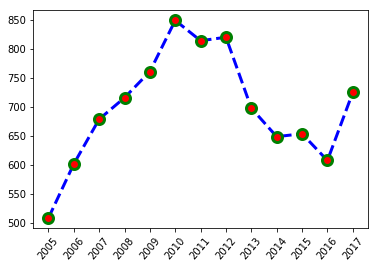

In [237]:
# 전체 키워드 트랜드 분석 (필터링 전)
ma.trend_analysis("all")

['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[30, 45, 25, 47, 45, 76, 44, 33, 25, 29, 28, 24, 24]


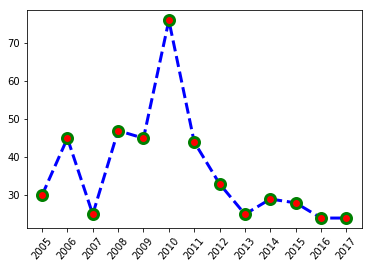

In [266]:
# 키워드 트랜드 분석
ma = MeReportAnalyzer()
ma.filtering_date('2005-01-01','2017-12-31')
ma.filtering_contents("쓰레기")
ma.trend_analysis("climate", False)

1218
Keyword Analysis


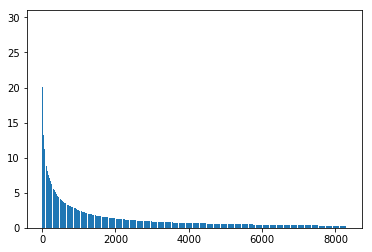

[('협력', 29.526404794277674),
 ('순환', 28.06166154972876),
 ('녹색', 24.668498683618868),
 ('기업', 24.36594774223062),
 ('에너지', 24.220087847857812),
 ('온실가스', 22.521118695086084),
 ('자원 순환', 21.19829008806392),
 ('매립', 20.6655601497009),
 ('공사', 20.15236759786973),
 ('제품', 20.05050470321107),
 ('물질', 20.001762875572293),
 ('억원', 19.160671435384746),
 ('환경 산업', 18.917907905950074),
 ('조사', 17.74133445376515),
 ('회의', 16.523367919011676),
 ('소각', 16.494813225722886),
 ('쓰레기', 15.95880451265801),
 ('협약', 15.919247353928444),
 ('공단', 15.898079843418884),
 ('평가', 15.829044937735192),
 ('건설', 15.720732914601896),
 ('감축', 14.97516836027691),
 ('국제', 14.968797132808985),
 ('포장', 14.719976827985391),
 ('연구', 14.623924292300304),
 ('단속', 14.57739659031015),
 ('지자체', 14.196302684935425),
 ('시스템', 14.184627300015833),
 ('폐기물 처리', 13.982353085936401),
 ('시멘트', 13.826330165537243),
 ('오염', 13.795026248047071),
 ('시장', 13.701206413322591),
 ('발전', 13.650519892768854),
 ('정보', 13.269952920237122),
 ('생활', 

In [243]:
# TF-IDF 기준
ma.keyword_analysis(200)

In [273]:
# 기후 관련 문장 추출

ma = MeReportAnalyzer()
ma.filtering_date('2005-01-01','2017-12-31')
ma.filtered_idx_result_df.tail(3)
ma.extract_sentence("기후")
ma.filtered_sentences

['기후변화와 기업의 대응에 관한 세미나 개최',
 '16를 앞두고 기후변화문제에 대한 기업의 대응방안을 점검하기 위해 환경부전경련KBCSD 등이 공동 주관하는 세미나 개최',
 '환경부 전경련 KBCSD 등은 금년 2월 16일 교토의정서의 발효를 앞두고 우리나라 기업의 기후변화협약에 대한 대응방안을 점검하고 효율적인 대책을 강구하기 위한 세미나를 공동으로 개최한다',
 '금번 세미나는 그동안 기후변화에 대한 업계의 대응이 실무자 차원에서 다루어지는 등 다소 미흡한 면이 있었으나 내달 16일 의정서 발효를 앞두고 관련업계의 대표 및 임원급을 대상으로 환경부와 산업계가 공동으로 개최하는 만큼 앞으로 업계차원의 대응방안 마련에 탄력을 받을 것으로 기대 된다',
 '7가 기후변화협약에 무방비이며 대비 못하는 이유로서 잘 몰라서32',
 '동 세미나에서는 지난해 아르헨티나에서 개최된 기후변화협약 제10차 당사국총회 주요논의 결과와 향후 전망에 대한 설명과',
 '아울러 \xa0정유 석유화학 철강 전기전자 자동차 등 온실가스 다량 배출 업계로부터 기후변화협약에 대비하는 기업차원의 대응방안에 대한 토론이 있을 예정이다',
 '이번 세미나에는 임원급 이상의 기업 관계자 연구기관 및 학계의 전문가 주요 NGO 등이 참가할 예정으로 있어 기후변화문제에 대한 기업의 인식 제고에 기여하고 온실가스 감축의 직접 당사자인 기업의 참여를 촉진하는 계기가 될 수 있을 것으로 전망 된다',
 '3목  국무총리 주재로기후변화협약대책위원회를 개최 2',
 '16일로 예정된 교토의정서 발효에 대비한기후변화협약 대응제3차 정부종합대책0507년을 심의확정하였음',
 '기후변화협약대책위원회  별첨 1',
 '이날 발표한 대책에서 정부는 향후 3년간 총 21조 5천억원을 투자 협약이행 기반구축사업 부문별 온실가스 감축사업 기후변화 적응기반 구축사업 등 3대 분야 90개 과제를 선정추진키로 하였음',
 '현재 우리나라는 기후변화협약상 개도국 지위에 있어 1차 공약기간0812년에는 의무부담이 없음',
 

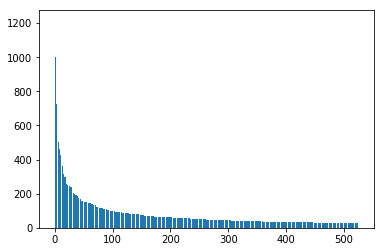

[('대응', 1214),
 ('기후변화 대응', 1002),
 ('기후', 915),
 ('적응', 727),
 ('온실가스', 572),
 ('협약', 534),
 ('녹색', 505),
 ('국가', 471),
 ('협력', 464),
 ('감축', 441),
 ('기후변화 적응', 426),
 ('계획', 407),
 ('기후변화 협약', 385),
 ('영향', 360),
 ('탄소', 353),
 ('회의', 314),
 ('지역', 304),
 ('에너지', 300),
 ('체제', 297),
 ('방안', 273),
 ('당사', 257),
 ('성장', 254),
 ('생태계', 253),
 ('변화', 250),
 ('온실가스 감축', 250),
 ('생물', 244),
 ('생물다양성', 243),
 ('대기', 241),
 ('협상', 241),
 ('공동', 238),
 ('정부', 238),
 ('녹색 성장', 228),
 ('지속', 205),
 ('주요', 204),
 ('지구', 198),
 ('배출', 198),
 ('지자체', 195),
 ('국민', 194),
 ('추진', 190),
 ('세계', 187),
 ('수립', 180),
 ('유엔', 177),
 ('대표', 174),
 ('협약 당사', 172),
 ('적극', 170),
 ('실천', 168),
 ('결과', 159),
 ('정보', 157),
 ('목표', 155),
 ('개도국', 155),
 ('생활', 154),
 ('강화', 154),
 ('체계', 153),
 ('센터', 153),
 ('문제', 152),
 ('국가 기후변화', 152),
 ('교육', 148),
 ('주제', 145),
 ('기후 대기', 145),
 ('논의', 144),
 ('향후', 143),
 ('보고서', 143),
 ('발전', 143),
 ('도시', 142),
 ('자원', 141),
 ('보전', 140),
 ('기후변화 영향', 136),
 ('사회', 136

In [274]:
ma.sentence_keyword_analysis()

In [7]:
ma.filtering_contents("기후변화")
ma.filtered_idx_result_df

,date,title,content_url_list,file_list
0,2015-01-08,탄소중립제품 첫 등장…탄소성적표지 제도의 선진화,http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150108_1.txt
1,2015-01-15,온실가스 배출권 할당 대상업체 525개 중 243개 업체가 이의신청,http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150115_1.txt
2,2015-01-28,온실가스 외부감축사업 상쇄제도 본격 시행,http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150128_2.txt
3,2015-02-02,탄소배출량 산정하고 기후변화 대응에 참여해요!,http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150202_1.txt
4,2015-02-10,"온실가스 배출권 670만KAU*, 예비분에서 추가적 할당",http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150210_1.txt
5,2015-02-24,한국 기후변화 평가보고서 2014 발간,http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150224_1.txt
6,2015-02-24,"환경부, 배출권거래제 상쇄제도 설명회 개최",http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150224_2.txt
7,2015-03-04,신기후체제 알리기 위해 정부·기업·민간단체 손잡다,http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150304_1.txt
8,2015-03-12,"국립생물자원관, 신종 무척추동물 올챙이새우류를 포함한 3,000점 동물표본...",http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150312_1.txt
9,2015-03-17,‘미세먼지 대응 방문교실’이 초등학교로 찾아갑니다,http://www.me.go.kr/home/web/board/read.do;jse...,/media/MeReportCrawler/result/20150317_1.txt


In [386]:
#ma.select_topic([3])
#ma.filtered_idx_result_df

In [32]:
#a = pd.read_csv("./tm_result/result_n_22_s1_topic_words.csv",header=None,index_col=None)

In [405]:
#a.iloc[:,21:25]
a

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,포장,정부 포상,철새,국립공원,쓰레기,시설,화학물질,공모전,협력,국립생태원,...,비점,폐기물,생물,조류,인사,실천,기후변화,자동차,단속,소음
1,운전,마당,이동,탐방,음식물,수질,제품,작품,녹색,체험,...,비점 오염,재활용,생물 자원,남조류,인사 발령,녹색,시장,미세먼지,점검,분쟁
2,친환경 운전,포상,이동 경로,공단,음식물 쓰레기,배출,제도,어린이,회의,교육,...,비점 오염원,자원,국립생물자원관,정수,보도자료,캠페인,감축,배출 가스,위반,배상
3,친환경,물의,경로,국립공원 공단,음식,처리,인증,질환,세계,생태,...,채용,순환,식물,지오,과장,그린,온실가스,가스,적발,분쟁 조정
4,과대,기념,철새 이동,습지,종량제,물질,정보,보건,기후변화,생태관광,...,기구,자원 순환,자원,발령,발령 보도자료,녹색 생활,진출,예보,배출,공사
5,포장재,포상 수여,철새 센터,공원,수거,오염,안전,수상작,포럼,프로그램,...,양성 과정,처리,자생,냄새,발령,생활,적응,차량,시설,조정
6,선물,휴식 공간,홍도,지리산,음식 문화,하수,시행,공모,성장,어린이,...,오염원,공사,생태계,세포,일자,온실가스,중국,배출,특별,진동
7,임원,포장,부착,자연,쓰레기 수거,측정,유해,아이디어,녹색 성장,가족,...,근무,광산,서식,팔당호,대변인,탄소,베트남,수도권,폐수,조정 위원회
8,수도권매립지 공사,휴식,장거리,생태,용기,개선,친환경,환경성 질환,공동,학교,...,모집,배출,개체,주의보,관실,운동,온실가스 감축,경유,불법,중앙 분쟁
9,수도권매립지,국무총리,장거리 이동,북한,연휴,온실가스,업체,상금,발전,청소년,...,석사,토양,야생,창업,전보,스타트,협상,충전,행위,신청
